In [38]:
import numpy as np
import pickle
import os
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS
import pandas as pd
from PIL import Image
from scipy.spatial.distance import pdist
from tqdm import tqdm
import glob as glob
import argparse
from scipy.stats import pearsonr
import hcp_utils as hcp
from pathlib import Path

In [39]:
def mds(utv, pos=None, n_jobs=1, n_components=2):
    #this function copied from NSD code
    """ pos = mds(utv)

    mds computes the multi-dimensional scaling solution on a 
    two dimensional plane, for a representational dissimilarity matrix.

    Args:

        utv (array): 1D upper (or lower) triangular part of an RDM

        pos (array, optional): set of 2D coordinates to initialise the MDS
                            with. Defaults to None.

        n_jobs (int, optional): number of cores to distribute to.
                            Defaults to 1.

    Returns:

        [array]: 2D aray of x and y coordinates.

    """

    rdm = squareform(utv)
    seed = np.random.RandomState(seed=3)
    mds = MDS(
        n_components=n_components,
        max_iter=100,
        random_state=seed,
        dissimilarity="precomputed",
        n_jobs=n_jobs
    )
    pos = mds.fit_transform(rdm, init=pos)

    return pos


In [40]:
def create_rdm(X: np.ndarray, method: str = 'pearson'):
    #fills in complete matrix
    #X is shape numstim x numvertices (i.e., features)
    numstim = X.shape[0]
    rdm = np.zeros((numstim,numstim))
    for i in range(numstim):
        for j in range(numstim):
            if method == 'pearson':
                rdm[i,j] = 1-pearsonr(X[i,:], X[j,:])[0]
    
    return rdm

In [66]:

class arguments:
    def __init__(self) -> None:
        self.subject = '1' 
        self.dataset_root = "/data/vision/oliva/scratch/datasets/HumanActionsDataset"
        self.project_root = "/data/vision/oliva/blahner/projects/SheenBrain/fmriDatasetPreparation/HumanActionsDataset/validation"
        self.image_plot = True #plot video frames on top tsne results
        self.n_components = 2
        self.perplexity = 30
        self.verbose = True

args = arguments()
subject = f"sub-{int(args.subject):02}"
session = "ses-action01"
hcp_roilist = list(hcp.mmp.labels.values())
ROI = "L_MT" # ['LO1', 'LO2', 'PHA1', 'PHA2', 'MT']

save_root = os.path.join(args.project_root, "output_tsne")
if not os.path.exists(save_root):
    os.makedirs(save_root)

In [67]:
#load fMRI data from that subject and ROI
fmri_data_wb = np.load(os.path.join(args.dataset_root, "derivatives", "GLM", subject, session, f"{subject}_organized_betas.npy")) #shape numstim, numreps, numvertices
roi_indices = np.where(hcp.mmp.map_all == hcp_roilist.index(ROI))[0] 
fmri_data_roi = np.mean(fmri_data_wb[:,:,roi_indices],axis=1) #average over reps

with open(os.path.join(args.dataset_root, "derivatives", "GLM", subject, session, f"{subject}_{session}_task-action_conditionOrderDM.pkl"), 'rb') as f:
    events_run, ses_conds = pickle.load(f)

(720, 720)


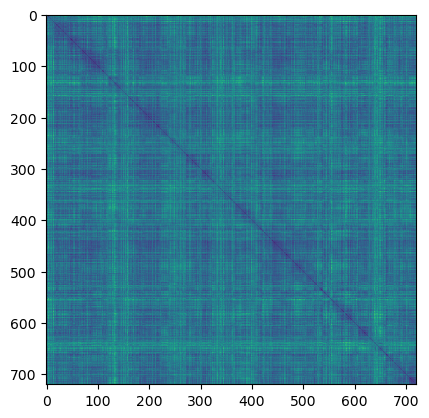

In [68]:
#compute ROI RDM
rdm_flat = pdist(fmri_data_roi, metric='correlation')
rdm = squareform(rdm_flat)
print(rdm.shape)
plt.imshow(rdm)

In [69]:

#compute MDS
Y_mds = mds(squareform(rdm), n_components=args.n_components)

tsne = TSNE(n_components=args.n_components, metric='precomputed', init=Y_mds, random_state=42, perplexity=args.perplexity, n_jobs=1)
X_tsne = tsne.fit_transform(rdm)
print("divergence: ", tsne.kl_divergence_)

/data/vision/oliva/blahner/anaconda3/envs/NeuroAI/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


divergence:  1.7533957958221436


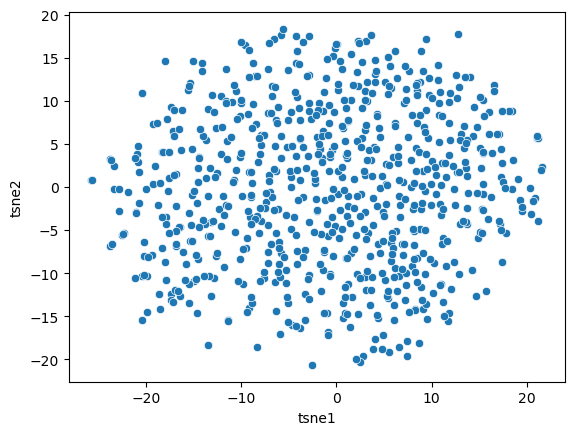

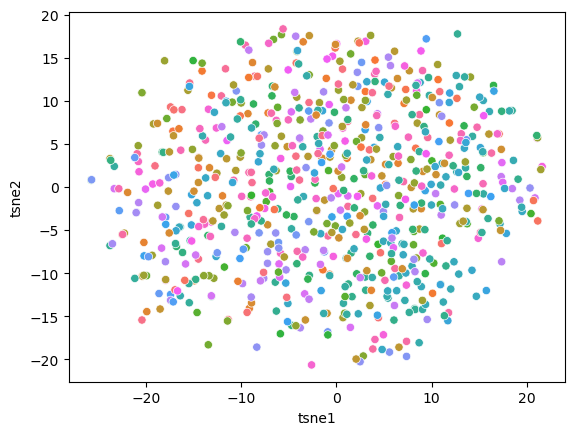

<Figure size 640x480 with 0 Axes>

In [70]:
#organize data into a pandas dataframe for much easier and more flexible plotting
cols = ['stimIDX', 'actionCategory'] #add columns for metadata labels, like face or no face, indoor vs outdoor, people vs no people
cols.extend(["tsne{}".format(n+1) for n in range(args.n_components)])
data_plot = {c: [] for c in cols}
for count, i in enumerate(ses_conds):
    stimIDX = f"stimIDX{count+1:05}"
    for r in range(args.n_components):
        data_plot['tsne{}'.format(str(r+1))].append(X_tsne[count, r])
    data_plot['stimIDX'].append(stimIDX)
    cat_tmp = i.split('_id')[0]
    category = cat_tmp.split('v_')[1]
    data_plot['actionCategory'].append(category)

df = pd.DataFrame(data_plot)
# no hue
sns.scatterplot(x = "tsne1", y = "tsne2", data = df)
plt.savefig(os.path.join(save_root, f"{subject}_ROI-{ROI}_tsne_dots.png"))
plt.show()
plt.clf()

sns.scatterplot(x = "tsne1", y = "tsne2", data = df, hue="actionCategory")
plt.legend('',frameon=False)
plt.savefig(os.path.join(save_root, f"{subject}_ROI-{ROI}_tsne_actionCategory.png"))
plt.show()
plt.clf()



stretch: 10.0
v_Drum corps
/data/vision/oliva/scratch/datasets/HumanActionsDataset/derivatives/stimuli_metadata/frames/Drum corps/v_Drum corps_id_0Qo8FzNJ460_start_28.0_label_1
v_Playing kickball
/data/vision/oliva/scratch/datasets/HumanActionsDataset/derivatives/stimuli_metadata/frames/Playing kickball/v_Playing kickball_id_HByszN4xrLU_start_106.5_label_1
v_Hand car wash
/data/vision/oliva/scratch/datasets/HumanActionsDataset/derivatives/stimuli_metadata/frames/Hand car wash/v_Hand car wash_id_HZW1njYbYPI_start_65.5_label_1
v_Shuffleboard
/data/vision/oliva/scratch/datasets/HumanActionsDataset/derivatives/stimuli_metadata/frames/Shuffleboard/v_Shuffleboard_id_iyz1BjhV1J4_start_4.5_label_1
v_Croquet
/data/vision/oliva/scratch/datasets/HumanActionsDataset/derivatives/stimuli_metadata/frames/Croquet/v_Croquet_id_Q_rVIfFRxbk_start_12.0_label_1
v_Fixing bicycle
/data/vision/oliva/scratch/datasets/HumanActionsDataset/derivatives/stimuli_metadata/frames/Fixing bicycle/v_Fixing bicycle_id_9Ph

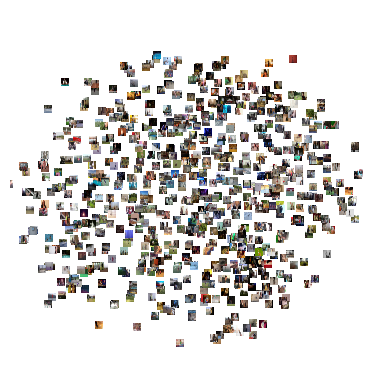

<Figure size 640x480 with 0 Axes>

In [71]:


#not setup for 3D plots
fig, ax = plt.subplots()
# Get the center coordinates of the plot
x_center = 250 #ax.get_xlim()[1] / 2
y_center = 250 #ax.get_ylim()[1] / 2
stretch = np.floor(500 / (np.abs(np.max(X_tsne.ravel())) + np.abs(np.min(X_tsne.ravel()))))
print("stretch:", stretch)
scaler = 0.04
for i, pat in enumerate(X_tsne):
    image_filename = ses_conds[i]
    cat_tmp = image_filename.split('_id')[0]
    category = cat_tmp.split('v_')[1]
    #find total number of frames
    image_path = os.path.join(args.dataset_root, "derivatives", "stimuli_metadata", "frames", f"{category}", f"{image_filename}")
    total_frames = len(list(Path(image_path).glob('*')))

    x, y = pat
    x_new = x_center + x*stretch
    y_new = y_center + y*stretch
    # plot middle frame 
    stimIDX = f"stimIDX{i+1:05}"
    img = np.array(Image.open(os.path.join(image_path, f"frame{str(int(total_frames/2))}_{total_frames}.jpg"))).astype(np.float64) /255 #.astype('uint8')
    ax.imshow(img, extent=[x_new, x_new+scaler*img.shape[1], y_new, y_new+scaler*img.shape[0]])
ax.set_xlim(0, 500)
ax.set_ylim(0, 500)
ax.set_aspect('equal')
ax.set_axis_off()
plt.savefig(os.path.join(save_root, f"{subject}_ROI-{ROI}_tsne_plotframes.png"), dpi=300)
plt.show()
plt.clf()